# Draft data processing

## To do

 - [ ] Clean trajectories (How?). Iterpolation, remove outliers (e.g. points outside path)
 - [ ] Calculate speed for every 1/3 second or something instead of frame-to-frame? It seems like there is a lot of noise (super high speeds), which could be due do video clitches.
 - [ ] Anotate video with CSV code. This could be usefull to troubleshoot data.
 

## Settings

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px


import os
import copy as cp

In [2]:
# Import custom functions 
# from utils import *

from modules.utils import *
from modules.draw import *
from modules.homography import PixelMapper

In [3]:

# PLotting params
plt.rcParams['figure.figsize'] = [15, 10]


Functions (move this somewhere else eventually)

In [4]:
# Plot inline function for one ore two images
def imgshow(img, img2 = None):
    if img2 is None:
        plt.imshow(img)
        # plt.title('World view')
        plt.show()
    else:
        plt.subplot(1, 2, 1)
        plt.imshow(img)


        plt.subplot(1, 2, 2)
        plt.imshow(img2)

        plt.tight_layout()

        plt.show()

        
# Homography plot functions
def draw_point(img, point, color, label = None):
    img_cp = cp.deepcopy(img)
    pcoords = tuple(point)
    cv2.circle(img_cp, pcoords, 4, color, -1)
    if label is not None:
        tcoords = tuple(point + 5)
        cv2.putText(img_cp, label, tcoords,  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    # ishow(img_cp)
    return img_cp


def draw_hom_points(img, points_array):
    img_cp = cp.deepcopy(img)
    # Loop over points
    i = 0
    for p in points_array:
        i += 1
        label = 'p' + str(i)
        img_cp = draw_point(img_cp, p, (0, 0, 255), label)
    return img_cp


## Load data

Load tabular data outputed by video-processing model

In [5]:
os.listdir('data')

['2-frame.jpg', '2-sample-30min.csv', '2-sat.jpg']

In [6]:
df = pd.read_csv('data/2-sample-30min.csv')

# Calculate centroids
df['cx'] =  round(df['xi'] + (df['xj'] - df['xi'])/2).astype(int)
df['cy'] =  round(df['yi'] + (df['yj'] - df['yi'])/2).astype(int)


Load images data

In [7]:
img_frame = cv2.imread('data/2-frame.jpg')
img_world = cv2.imread('data/2-sat.jpg')


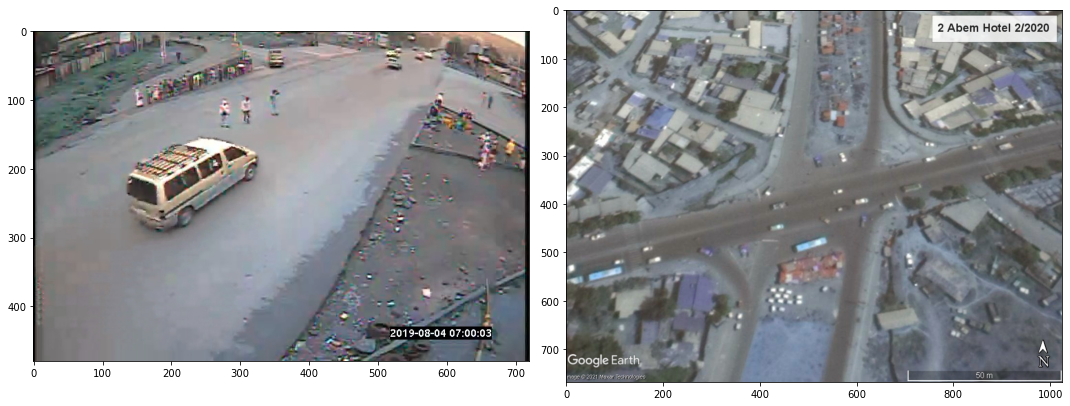

In [8]:
imgshow(img_frame, img_world)

In [9]:
img_frame.shape

(480, 720, 3)

## Homography

Homography points defintion: Set the same points in both images and coordinates

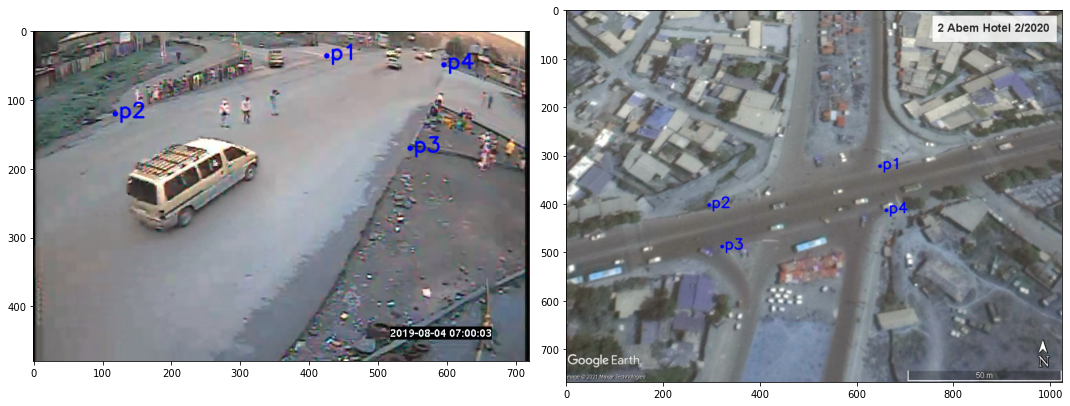

In [10]:
# Create one instance of PixelMapper to convert video frames to coordinates
quad_coords = {
#     # Unprojected
#     "lonlat": np.array([
#         [9.035947, 38.853956], # P1 top right
#         [9.035794, 38.853338], # P2 top left
#         [9.035631, 38.853425], # P3 bottom left
#         [9.035782, 38.853971] #  P4 bottom right
#     ]),
    # UTM
    "lonlat": np.array([
        [998829.59, 483949.29], # P1 top right
        [998812.71, 483881.37], # P2 top left
        [998794.68, 483890.92], # P3 bottom left
        [998811.35, 483950.93] #  P4 bottom right
    ]),
    "pixel": np.array([
        [426, 37], #  P1 top right
        [119, 121], #  P2 top left
        [547, 171], # P3 bottom left
        [596, 50] # P4 bottom right
    ]),
    "pixel_sat": np.array([
        [648, 322], # P1 top right
        [295, 402], # P2 top left
        [322, 488], #  P3 bottom left
        [661, 413] # P4 bottom right
    ])
}

# Display image points. 
img_s_points = draw_hom_points(img_world, quad_coords['pixel_sat'])
img_f_points = draw_hom_points(img_frame, quad_coords['pixel'])
imgshow(img_f_points, img_s_points)

PixelMapper class converts coordinates in pixels to lat-long

In [11]:
# Create pixel maper instance to convert from video to lat long (and vice versa)
pm = PixelMapper(quad_coords["pixel"], quad_coords["lonlat"])

# Create pixel maper instance to convert from sat image to lat long (and vice versa)
pm_sat = PixelMapper(quad_coords["pixel_sat"], quad_coords["lonlat"])

Test trajectory to see if homography is working:

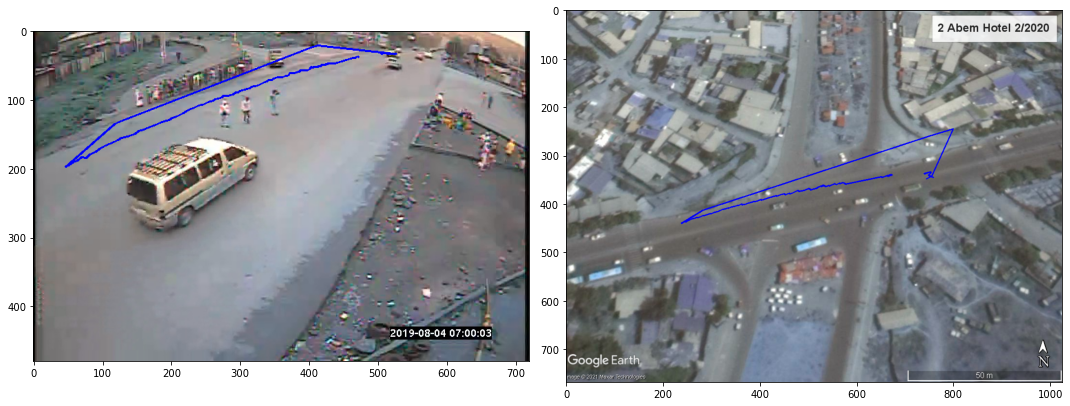

In [12]:
# To do
# - Make sure trajectories are in frame order
# - Organize this into a function



def draw_trajectory(img, trajectory_array, color):
    img_cp = cp.deepcopy(img)
    for p in range(1, len(trajectory_array)):
            cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
    return img_cp


# Create trajectory df
car_df = df[df['obj_id'] == 15]

t_car = car_df[['cx', 'cy']].to_numpy()

# Anotate trajectory on initial video frame
img_cf = img_frame.copy()
img_cf = draw_trajectory(img_cf, t_car, (0, 0, 255))

# # ishow(img_cf)

# Transform trajectories to long lat
t_car_ll = pm.pixel_to_lonlat(t_car) # t_car created in draft-intersections.py

# Transform lat long trajectory into pixels of sat image
t_car_s = pm_sat.lonlat_to_pixel(t_car_ll).astype(int)

# # Anotate trajectory on sat image
img_cs = img_world.copy()
img_cs = draw_trajectory(img_cs, t_car_s, (0, 0, 255))

imgshow(img_cf, img_cs)

In [13]:
car_df

frame   xi  yi   xj  yj  obj_id  class   cx  cy
64        7  462  28  483  48      15      2  472  38
75        8  462  30  481  48      15      2  472  39
87        9  462  30  481  48      15      2  472  39
99       10  460  30  480  47      15      2  470  38
110      11  459  29  480  48      15      2  470  38
...     ...  ...  ..  ...  ..     ...    ...  ...  ..
3458    326  490  20  522  47      15      2  506  34
3471    327  490  21  522  47      15      2  506  34
3482    328  489  20  521  47      15      2  505  34
3493    329  490  21  521  48      15      2  506  34
3505    330  489  21  521  48      15      2  505  34

[177 rows x 9 columns]

In [14]:
fig = px.scatter(car_df, x="cx", y="cy", text="frame", log_x=True, size_max=60)
fig.show()

In [15]:
trajectory_array = t_car 
color = (0, 0, 255)
img_cp = cp.deepcopy(img_frame)

for p in range(1, len(trajectory_array)):
    cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
ishow(img_cp)

In [16]:
# cv2.destroyAllWindows() 

## Path definition

Define preliminary east through movement

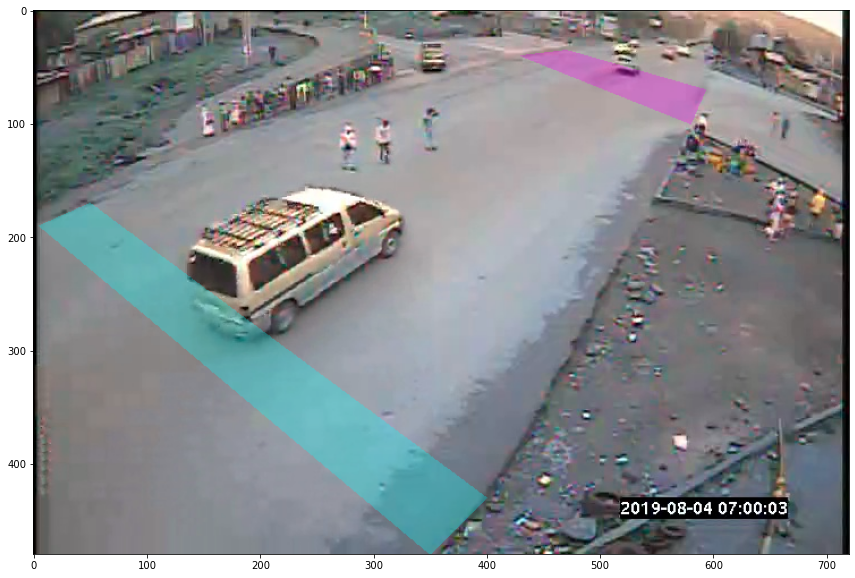

In [17]:
overlay = cp.deepcopy(img_frame)
image_new = cp.deepcopy(img_frame)

# x, y, w, h = 10, 10, 10, 10  # Rectangle parameters
# cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 200, 0), -1)  # A filled rectangle

# First trajectory area
contours1 = np.array([[5,190], # top left 
                     [350,480], # bottom left
                     [400,430], # bottom right
                     [50,170]]) # top right
# Second trajectory area
contours2 = np.array([[430,40], # top left 
                     [580,100], # bottom left
                     [593,70], # bottom right
                     [470,35]]) # top right


alpha = 0.3  # Transparency factor.
poly1 = cv2.fillPoly(overlay, pts = [contours1], color =(0,255,255))
poly2 = cv2.fillPoly(overlay, pts = [contours2], color =(255,0,255))


# Following line overlays transparent rectangle over the image
image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)

imgshow(image_new)

Filter only trajectories that match the movement (o try to)

In [65]:
# Test trajectory

trj_temp = df[df['obj_id'] == 15]; trj_temp

p_temp = tuple(trj_temp.iloc[2][['cx','cy']]); p_temp

(472, 39)

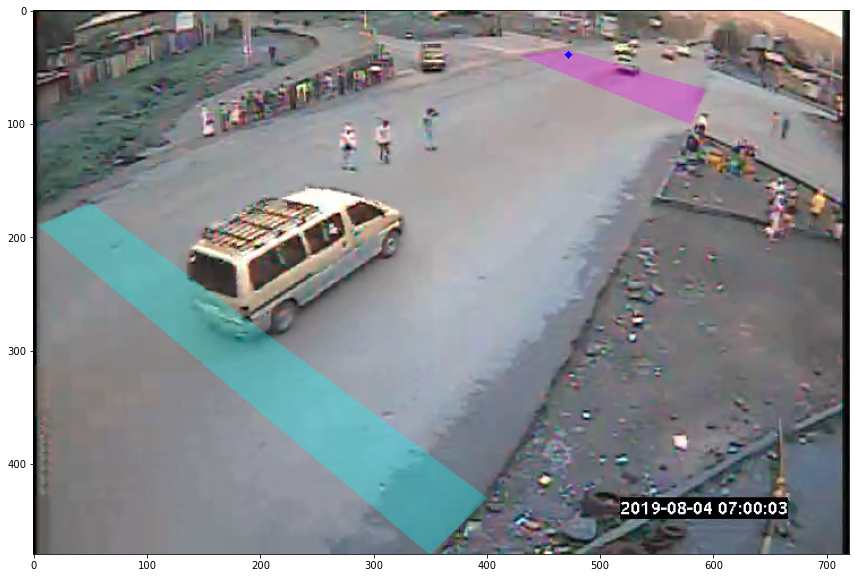

In [19]:
image_new_cp = cp.deepcopy(image_new)
cv2.circle(image_new_cp, tuple(p_temp), radius=1, color=(0, 0, 255), thickness=3)

imgshow(image_new_cp)

Test if any points in the trajectory are in the defined areas. Idea is that if there are points in both, that trajectory is part of a pre defined movement.

In [21]:

# Copy image to anotate with trajectory
image_new_cp = cp.deepcopy(image_new)

# Test each point individually. Try a more efficient way!


bol_area1 = []
bol_area2 = []

for i in range(0, len(trj_temp)):
    p_i = tuple(trj_temp.iloc[i][['cx', 'cy']])
    
    # Test if points in area
    bol_area1.append(cv2.pointPolygonTest(contours1, p_i, False))
    bol_area2.append(cv2.pointPolygonTest(contours2, p_i, False))

    cv2.circle(image_new_cp, tuple(p_i), radius=1, color=(0, 0, 255), thickness=3)
#     print(p_i)
#     print(bol)

# Test if any point in area
any(bol_area1)

any(bol_area2)

True

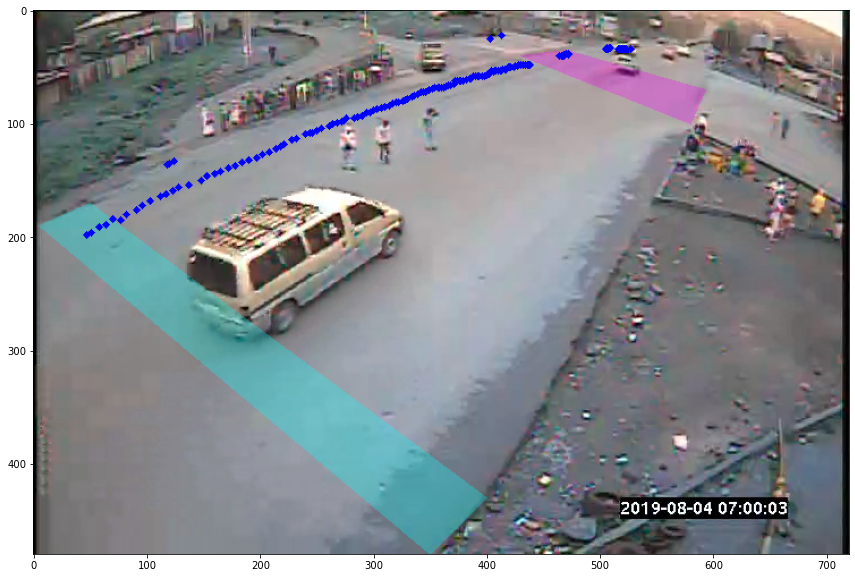

In [22]:
imgshow(image_new_cp)


##  Calculate point speed

In [23]:
# Test distance between reference points to see if consistent

In [27]:
quad_coords['lonlat'][0]

array([998829.59, 483949.29])

In [131]:
quad_coords['lonlat'][1]

array([998812.71, 483881.37])

In [133]:
998829.59-998812.71

16.880000000004657

In [31]:

# math.dist(quad_coords['lonlat'][0], quad_coords['lonlat'][1])

# quad_coords['lonlat'][0] - quad_coords['lonlat'][1]
np.linalg.norm(quad_coords['lonlat'][0] - quad_coords['lonlat'][1])


69.98614720069925

In [130]:
quad_coords['lonlat'][0] - quad_coords['lonlat'][1]

array([16.88, 67.92])

In [153]:
# Create trajectory df
trj_temp = df[df['obj_id'].isin([1,15])]
# trj_temp = df[df['obj_id'].isin([15])]


t_temp = trj_temp[['cx', 'cy']].to_numpy()


# # ishow(img_cf)

# Transform trajectories to long lat
t_temp_ll = pm.pixel_to_lonlat(t_temp) # t_car created in draft-intersections.py

In [154]:
foo = pd.DataFrame(t_temp_ll)
foo.columns = ['c_lat', 'c_long']
# foo

In [155]:
new_df = pd.concat([trj_temp.reset_index(drop=True), foo.reset_index(drop=True)], axis=1)
new_df = new_df.sort_values(['obj_id', 'frame'])

In [156]:
# lag variable
# shifted = new_df.groupby("obj_id") #.shift(1) 
# shifted = new_df.shift(1)[['frame', 'obj_id', 'c_lat', 'c_long']]


new_df['c_lat_l'] = new_df.groupby(['obj_id'])['c_lat'].shift(1)
new_df['c_long_l'] = new_df.groupby(['obj_id'])['c_long'].shift(1)

new_df


# df_new.join(shifted, rsuffix = '_l')
# new_df.shape

frame   xi   yi   xj   yj  obj_id  class   cx   cy          c_lat  \
0        2  448  216  481  308       1      0  464  262  998792.089436   
1        3  448  216  481  307       1      0  464  262  998792.089436   
2        4  448  215  482  308       1      0  465  262  998792.072463   
3        5  457  204  492  300       1      0  474  252  998792.275245   
4        6  460  200  497  299       1      0  478  250  998792.278610   
..     ...  ...  ...  ...  ...     ...    ...  ...  ...            ...   
305    326  490   20  522   47      15      2  506   34  998825.825644   
306    327  490   21  522   47      15      2  506   34  998825.825644   
307    328  489   20  521   47      15      2  505   34  998825.900968   
308    329  490   21  521   48      15      2  506   34  998825.825644   
309    330  489   21  521   48      15      2  505   34  998825.900968   

            c_long        c_lat_l       c_long_l  
0    483877.619475            NaN            NaN  
1    483877.619475  998792.089436  483877.619475  
2    483877.645084  998792.089436  483877.619475  
3    483878.678554  998792.072463  483877.645084  
4    483878.953056  998792.275245  483878.678554  
..             ...            ...            ...  
305  483963.966124  998825.825644  483963.966124  
306  483963.966124  998825.825644  483963.966124  
307  483963.837492  998825.825644  483963.966124  
308  483963.966124  998825.900968  483963.837492  
309  483963.837492  998825.825644  483963.966124  

[310 rows x 13 columns]

In [160]:
# Calculate distance from point to point lag for the whole data

from scipy.spatial.distance import cdist

foo = cdist(new_df[['c_lat', 'c_long']], new_df[['c_lat_l', 'c_long_l']], 'euclid')
new_df['dist_m'] = np.diagonal(foo)

new_df

frame   xi   yi   xj   yj  obj_id  class   cx   cy          c_lat  \
0        2  448  216  481  308       1      0  464  262  998792.089436   
1        3  448  216  481  307       1      0  464  262  998792.089436   
2        4  448  215  482  308       1      0  465  262  998792.072463   
3        5  457  204  492  300       1      0  474  252  998792.275245   
4        6  460  200  497  299       1      0  478  250  998792.278610   
..     ...  ...  ...  ...  ...     ...    ...  ...  ...            ...   
305    326  490   20  522   47      15      2  506   34  998825.825644   
306    327  490   21  522   47      15      2  506   34  998825.825644   
307    328  489   20  521   47      15      2  505   34  998825.900968   
308    329  490   21  521   48      15      2  506   34  998825.825644   
309    330  489   21  521   48      15      2  505   34  998825.900968   

            c_long        c_lat_l       c_long_l      dist    dist_m  
0    483877.619475            NaN            NaN       NaN       NaN  
1    483877.619475  998792.089436  483877.619475  0.000000  0.000000  
2    483877.645084  998792.089436  483877.619475  0.030723  0.030723  
3    483878.678554  998792.072463  483877.645084  1.053176  1.053176  
4    483878.953056  998792.275245  483878.678554  0.274523  0.274523  
..             ...            ...            ...       ...       ...  
305  483963.966124  998825.825644  483963.966124  0.000000  0.000000  
306  483963.966124  998825.825644  483963.966124  0.000000  0.000000  
307  483963.837492  998825.825644  483963.966124  0.149063  0.149063  
308  483963.966124  998825.900968  483963.837492  0.149063  0.149063  
309  483963.837492  998825.825644  483963.966124  0.149063  0.149063  

[310 rows x 15 columns]

In [172]:
pd.set_option("max_rows", None)


# Calculate speed
fps = 30

new_df['speed_ms'] = new_df['dist_m']/(1/fps)
new_df['speed_kmh'] = new_df['speed_ms']*3.6
new_df[['frame', 'obj_id', 'cx', 'cy', 'c_lat','c_long', 'c_lat_l', 'c_long_l', 'dist', 'dist_m', 'speed_ms','speed_kmh']]




frame  obj_id   cx   cy          c_lat         c_long        c_lat_l  \
0        2       1  464  262  998792.089436  483877.619475            NaN   
1        3       1  464  262  998792.089436  483877.619475  998792.089436   
2        4       1  465  262  998792.072463  483877.645084  998792.089436   
3        5       1  474  252  998792.275245  483878.678554  998792.072463   
4        6       1  478  250  998792.278610  483878.953056  998792.275245   
5        7       1  480  248  998792.317691  483879.177673  998792.278610   
7        8       1  482  246  998792.357346  483879.405585  998792.317691   
9        9       1  482  242  998792.511330  483879.761306  998792.357346   
11      10       1  481  242  998792.529554  483879.733740  998792.511330   
13      11       1  480  238  998792.706921  483880.071724  998792.529554   
15      12       1  481  236  998792.769667  483880.286847  998792.706921   
17      13       1  482  235  998792.792048  483880.409794  998792.769667   
19      14       1  482  234  998792.833372  483880.505257  998792.792048   
21      15       1  482  234  998792.833372  483880.505257  998792.833372   
23      16       1  482  234  998792.833372  483880.505257  998792.833372   
25      17       1  484  232  998792.879144  483880.755682  998792.833372   
27      18       1  486  231  998792.883308  483880.911119  998792.879144   
28      19       1  486  230  998792.925628  483881.010007  998792.883308   
29      20       1  488  230  998792.887504  483881.067774  998792.925628   
30      21       1  488  230  998792.887504  483881.067774  998792.887504   
31      22       1  488  230  998792.887504  483881.067774  998792.887504   
32      23       1  488  228  998792.972842  483881.268325  998792.887504   
33      24       1  488  226  998793.059521  483881.472026  998792.972842   
34      25       1  488  226  998793.059521  483881.472026  998793.059521   
35      26       1  490  225  998793.064505  483881.634022  998793.059521   
36      27       1  489  224  998793.128064  483881.708543  998793.064505   
37      28       1  490  222  998793.197704  483881.948847  998793.128064   
38      29       1  490  222  998793.197704  483881.948847  998793.197704   
39      30       1  490  222  998793.197704  483881.948847  998793.197704   
40      31       1  491  220  998793.268469  483882.193033  998793.197704   
41      32       1  492  224  998793.069529  483881.797317  998793.268469   
42      33       1  493  220  998793.228825  483882.253196  998793.069529   
43      34       1  494  219  998793.254527  483882.392129  998793.228825   
44      35       1  494  218  998793.300423  483882.501860  998793.254527   
45      36       1  494  218  998793.300423  483882.501860  998793.300423   
46      37       1  494  216  998793.393341  483882.724015  998793.300423   
47      38       1  495  215  998793.420146  483882.867180  998793.393341   
48      39       1  495  214  998793.467483  483882.980683  998793.420146   
50      40       1  496  212  998793.542863  483883.241634  998793.467483   
52      41       1  496  211  998793.591306  483883.358125  998793.542863   
54      42       1  496  210  998793.640156  483883.475593  998793.591306   
56      43       1  496  209  998793.689417  483883.594050  998793.640156   
58      44       1  496  208  998793.739094  483883.713509  998793.689417   
60      45       1  496  208  998793.739094  483883.713509  998793.739094   
62      46       1  496  207  998793.789194  483883.833982  998793.739094   
64      47       1  496  207  998793.789194  483883.833982  998793.789194   
66      48       1  499  206  998793.776743  483884.051285  998793.789194   
68      49       1  500  206  998793.755748  483884.083223  998793.776743   
70      50       1  500  204  998793.857395  483884.330487  998793.755748   
72      51       1  501  204  998793.836221  483884.362709  998793.857395   
74      52       1  502  201  998793.970293  483884.774775  998793.836221   
7

In [164]:
new_df.columns

Index(['frame', 'xi', 'yi', 'xj', 'yj', 'obj_id', 'class', 'cx', 'cy', 'c_lat',
       'c_long', 'c_lat_l', 'c_long_l', 'dist', 'dist_m', 'speed_ms',
       'speed_kmh'],
      dtype='object')

In [148]:
# Comaparing two functions
# np.linalg.norm(np.array([998792.072463,483877.645084]) - np.array([998792.089436, 483877.619475]))

0.030723014351969558

In [48]:
t_temp_ll.shape

(177, 2)

In [32]:
trj_temp

frame   xi  yi   xj  yj  obj_id  class   cx  cy
64        7  462  28  483  48      15      2  472  38
75        8  462  30  481  48      15      2  472  39
87        9  462  30  481  48      15      2  472  39
99       10  460  30  480  47      15      2  470  38
110      11  459  29  480  48      15      2  470  38
...     ...  ...  ..  ...  ..     ...    ...  ...  ..
3458    326  490  20  522  47      15      2  506  34
3471    327  490  21  522  47      15      2  506  34
3482    328  489  20  521  47      15      2  505  34
3493    329  490  21  521  48      15      2  506  34
3505    330  489  21  521  48      15      2  505  34

[177 rows x 9 columns]

# DRAFT

In [ ]:
#----------------------------------------------------
# Use mouse to find points (or try to at least)


# Marker and grab position function

img = cp.deepcopy(img_frame)
mouseX,mouseY = 0,0

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),3,(255,0,0),1)
        mouseX,mouseY = x,y
        

# A window that will capture the mouse click
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw_circle)

# while(1):
#     cv2.imshow('image',img)
#     # Kill window if Q is pressed
#     k = cv2.waitKey(1) & 0xFF
#     if k == ord('q'):
#         cv2.destroyAllWindows()
#         break
#     elif k == ord('a'):
#         print(mouseX,mouseY)
# print(mouseX,mouseY)